COVID Global Forecast: SIR model + Regressions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_error, r2_score,mean_absolute_error

In [2]:
# Load datasets
train = pd.read_csv(r"C:\Users\Administrator\Desktop\Vinuwara_IRP_A.I.D.S_2024\Code\Dataset\Dataset.csv")

In [3]:
# Shuffle data before splitting
train = train.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
# Split into 80% train, 10% validation, and 10% test
train_data, temp_data = train_test_split(train, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [6]:
# Display dataset sizes
print("Training data size:", len(train_data))
print("Validation data size:", len(val_data))
print("Test data size:", len(test_data))

Training data size: 1485
Validation data size: 186
Test data size: 186


In [6]:
display(train.head(5))

,Date_reported,Country,Country_code,New_cases,Total_Infected,New_deaths,Total_Deaths,Susceptible,Recoverd
0,8/24/2020,Sri Lanka,LK,6,2953,0,12,23226517,2941
1,3/29/2021,Sri Lanka,LK,215,92303,5,566,23137167,91737
2,4/19/2023,Sri Lanka,LK,8,672118,0,16835,22557352,655283
3,9/8/2023,Sri Lanka,LK,0,672579,0,16882,22556891,655697
4,2/18/2021,Sri Lanka,LK,514,78420,8,430,23151050,77990


COVID-19 tendency

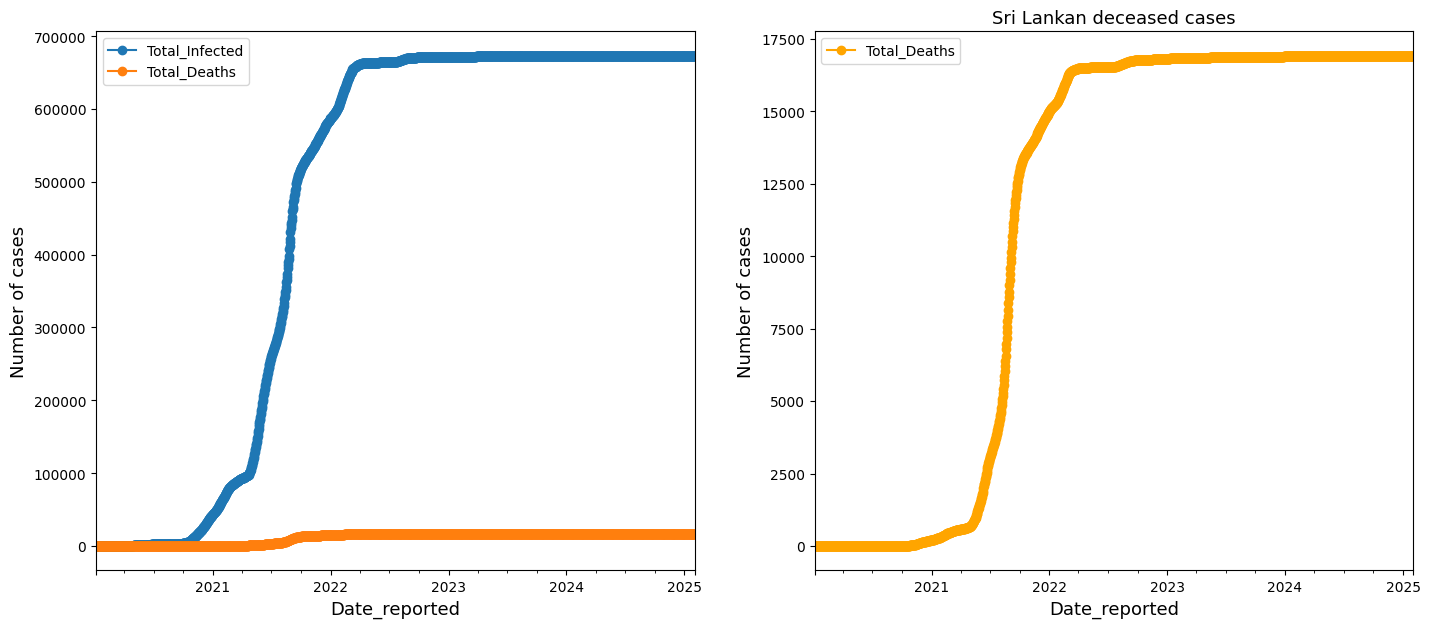

In [7]:
# Convert Date_reported to datetime
train['Date_reported'] = pd.to_datetime(train['Date_reported'])

# Group by Date and sum the values
confirmed_total_date = train.groupby('Date_reported').agg({'Total_Infected': 'sum'})
fatalities_total_date = train.groupby('Date_reported').agg({'Total_Deaths': 'sum'})

# Join both datasets
total_date = confirmed_total_date.join(fatalities_total_date)

# Plot the graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 7))

# Use line plot instead of default (bar plot)
total_date.plot(ax=ax1, linestyle='-', marker='o')  # Line plot with markers
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date_reported", size=13)

fatalities_total_date.plot(ax=ax2, color='orange', linestyle='-', marker='o')
ax2.set_title("Sri Lankan deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date_reported", size=13)

plt.show()




Observations:

    Infected criteria. The moment in which the criteria to consider an infected case was changed is direclty spotted
    Irregularities. There are some iregularities. I should check the literature in depth to look for evidences, but the reasons may be that both the resources spent to monitor the epidemy and the security measures to stop ot have been changing over time
    Plateaux. It looks like the curve has reached a plateaux, which would imply that Sri Lanka is on their maximum of contagion



Implementing the SIR model

SIR model

We have seen some general behavior of the virus in agregated data, for the country where the coronavirus was originated and for four other interesting countries. There's a lot of information to be extracted from this data; for example, we haven't analyzed the effects of long/lat of countries. However, since our main purpose is to develop a predective model in order to understand the key factors that impact the COVID-19 transmission, I'll move on to one of the most famous epidemiologic models: SIR.

SIR is a simple model that considers a population that belongs to one of the following states:

    Susceptible (S). The individual hasn't contracted the disease, but she can be infected due to transmisison from infected people
    Infected (I). This person has contracted the disease
    Recovered/Deceased (R). The disease may lead to one of two destinies: either the person survives, hence developing inmunity to the disease, or the person is deceased.



In [8]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc



In order to solve the differential equations system, we develop a 4rth order Runge-Kutta method:


In [9]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

This is an implementation of the 4th-order Runge-Kutta (RK4) method for solving a system of three ordinary differential equations (ODEs). In this case, it is applied to an SIR (Susceptible-Infected-Recovered) epidemic model with three variables:

    a (Susceptible)
    b (Infected)
    c (Recovered)
    
    Breakdown of the Code:

    Inputs:
        N:Total population
        a, b, c: Current values of susceptible, infected, and recovered individuals
        fa, fb, fc: Functions that define the rate of change for each variable
        beta: Infection rate
        gamma: Recovery rate
        hs: Step size for numerical integration

    RK4 Method Steps:
        Computes four approximations (a1 to a4, b1 to b4, c1 to c4) for each variable at different points.
        Uses these approximations to estimate the next values of a,b,ca,b,c.

    Final Update:
        The next values of a,b,ca,b,c are computed using the weighted sum of the four approximations.

Explanation of RK4:

For a general ODE dy/dt=f(y,t)dy/dt=f(y,t), RK4 estimates the next value yn+1yn+1​ as:
yn+1=yn+h6(k1+2k2+2k3+k4)
yn+1​=yn​+6h​(k1​+2k2​+2k3​+k4​)

where:

    k1=f(yn,tn)k1​=f(yn​,tn​)
    k2=f(yn+h2k1,tn+h2)k2​=f(yn​+2h​k1​,tn​+2h​)
    k3=f(yn+h2k2,tn+h2)k3​=f(yn​+2h​k2​,tn​+2h​)
    k4=f(yn+hk3,tn+h)k4​=f(yn​+hk3​,tn​+h)

In this case, the method is applied to the SIR model, where:
dSdt=−βSI
dtdS​=−βSI
dIdt=βSI−γI
dtdI​=βSI−γI
dRdt=γI
dtdR​=γI

These are computed using the fa, fb, and fc functions.



And finally, to obtain the evolution of the disease we simply define the initial conditions and call the rk4 method:


In [10]:
def SIR(N, b0, beta, gamma, hs):

    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """

    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

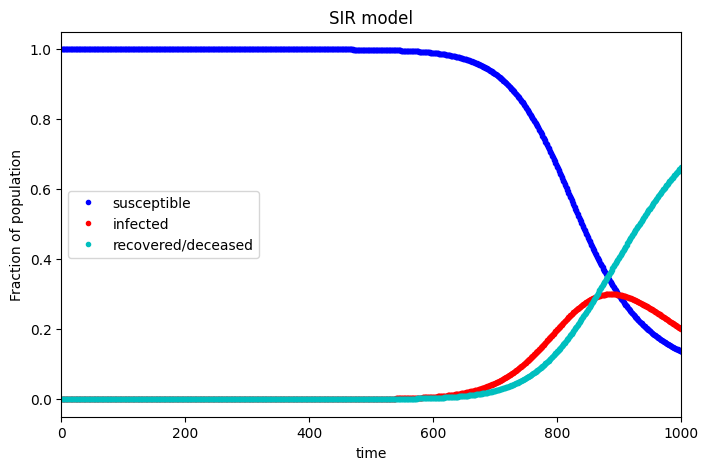

In [11]:
# Parameters of the model
N = 23229470 # SL population
b0 = 0
beta = 0.3
gamma = 0.1
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5))
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

Observations:

    The number of infected cases increases for a certain time period, and then eventually decreases given that individuals recover/decease from the disease
    The susceptible fraction of population decreases as the virus is transmited, to eventually drop to the absorbent state 0
    The oposite happens for the recovered/deceased case


Fit SIR parameters to real data

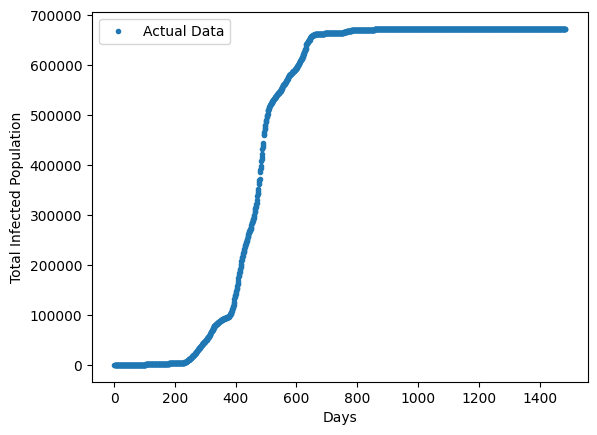

Optimal parameters: beta = 1.0 and gamma = 1.0


In [17]:
country_df = train_data[train_data['Country'] == 'Sri Lanka'].copy()

# Sort by date to ensure chronological order
country_df['Date_reported'] = pd.to_datetime(country_df['Date_reported'])
country_df = country_df.sort_values('Date_reported')

# Use Total_Infected as ydata
ydata = country_df['Total_Infected'].values
xdata = np.arange(1, len(ydata) + 1)  # Day count starting from 1

# Population (assuming constant susceptibility)
population = float(23229470)  # Use the first value as population

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

# Define the SIR model

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

# Define the function to fit the ODE model
def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:, 1]

# Fit the SIR model to the data
popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

# Plot the results
plt.plot(xdata, ydata,'.', label='Actual Data')
plt.ylabel("Total Infected Population")
plt.xlabel("Days")
plt.legend()
plt.show()

# Print optimal parameters
print("Optimal parameters: beta =", popt[0], "and gamma =", popt[1])

Visual representation for 6 months informed, starting on 2020-01-04 with linear and logarithmic scales

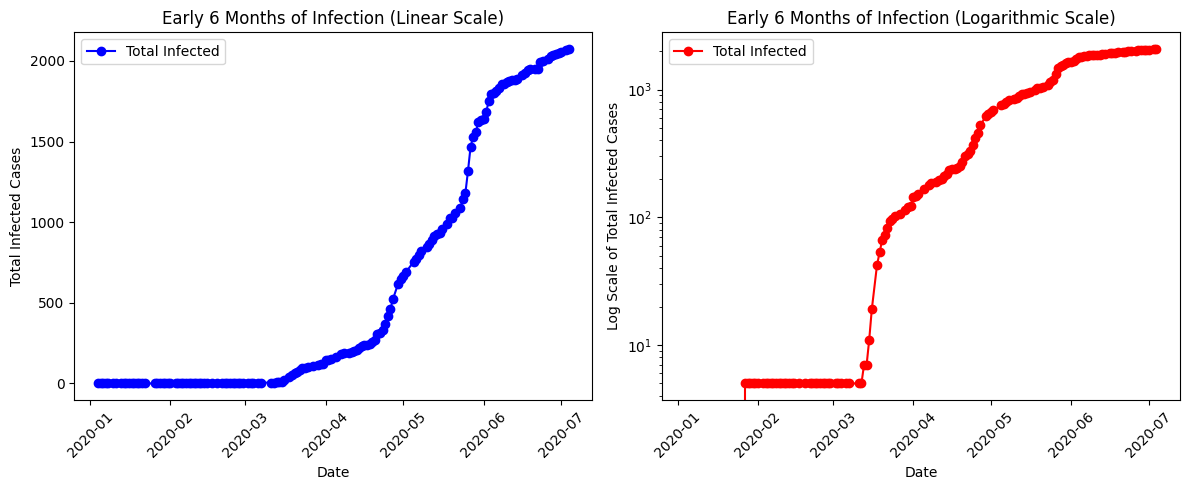

In [18]:
# Filter data for the first few months
first_months_df = country_df[country_df['Date_reported'] <= country_df['Date_reported'].min() + pd.DateOffset(months=6)]

# Convert dates to numeric for plotting
x_dates = first_months_df['Date_reported']
y_cases = first_months_df['Total_Infected']

# Plot with linear scale
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # First subplot
plt.plot(x_dates, y_cases, 'bo-', label='Total Infected')
plt.xlabel("Date")
plt.ylabel("Total Infected Cases")
plt.xticks(rotation=45)
plt.title("Early 6 Months of Infection (Linear Scale)")
plt.legend()

# Plot with logarithmic scale
plt.subplot(1, 2, 2)  # Second subplot
plt.plot(x_dates, y_cases, 'ro-', label='Total Infected')
plt.yscale('log')  # Apply log scale
plt.xlabel("Date")
plt.ylabel("Log Scale of Total Infected Cases")
plt.xticks(rotation=45)
plt.title("Early 6 Months of Infection (Logarithmic Scale)")
plt.legend()

plt.tight_layout()
plt.show()


Why do I only extract the last 90 days of data? For two reasons:

    In order to capture exactly the very short term component of the evolution
    To prevent the effects of certain variables that have been impacting the transmition speed (quarantine vs free circulation)

Basic Linear Regression model:

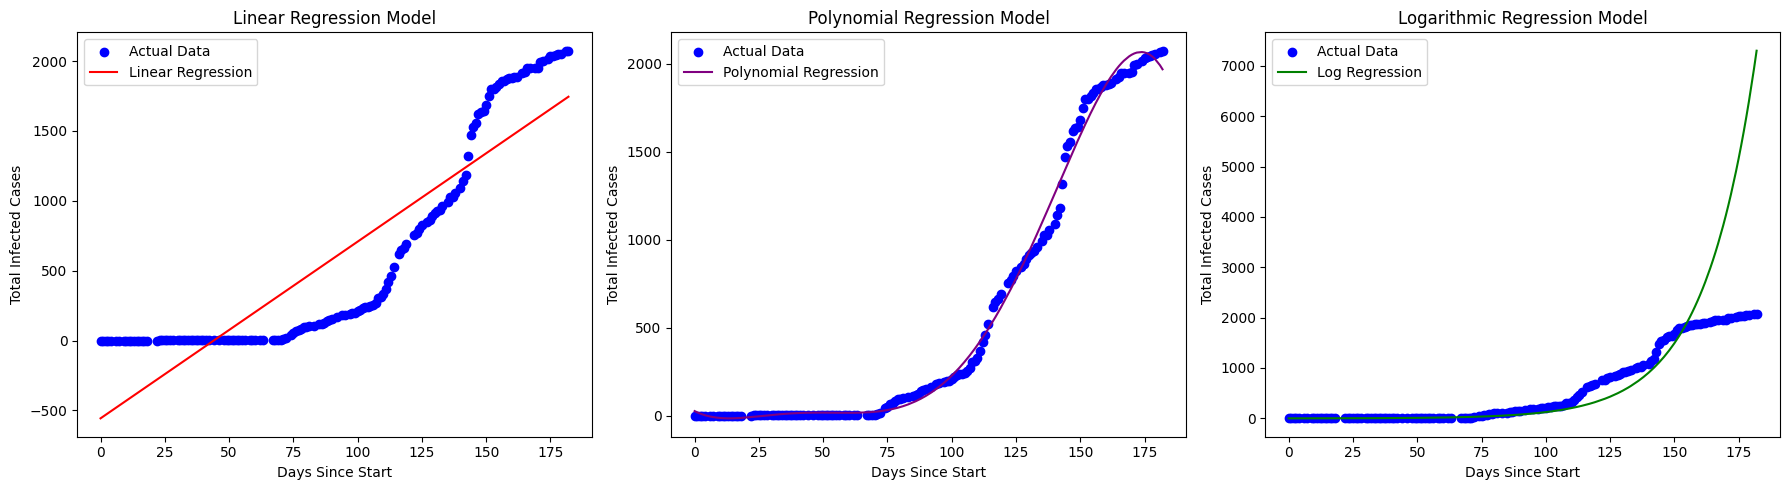

Linear Regression Coefficients:
Slope: 12.646656545972316 Intercept: -557.0127898220812

Polynomial Regression Coefficients:
Coefficients: [ 0.00000000e+00 -7.40521550e+00  4.33227730e-01 -9.23882534e-03
  8.01845836e-05 -2.17049378e-07] Intercept: 27.070663678325673

Logarithmic Regression Coefficients:
Slope: 0.04964226074305719 Intercept: -0.13878976155617995


In [19]:
# Convert dates to numeric for regression
# Filter data for the first 12 months
first_year_df = country_df[country_df['Date_reported'] <= country_df['Date_reported'].min() + pd.DateOffset(months=6)]

# Convert dates to numeric for regression
first_year_df['Days_Since_Start'] = (first_year_df['Date_reported'] - first_year_df['Date_reported'].min()).dt.days
X = first_year_df[['Days_Since_Start']].values  # Feature
Y = first_year_df['Total_Infected'].values  # Target

# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X, Y)
linear_pred = linear_model.predict(X)

# Polynomial Regression Model
poly = PolynomialFeatures(degree=5)  # degree to fit the data better
X_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, Y)
poly_pred = poly_model.predict(X_poly)

# Logarithmic Regression Model (log-transform Y)
log_Y = np.log(Y + 1)  # Adding 1 to avoid log(0)
log_model = LinearRegression()
log_model.fit(X, log_Y)
log_pred = np.exp(log_model.predict(X)) - 1  # Inverse transform

# Plot Linear Regression
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(X, Y, color='blue', label='Actual Data')
plt.plot(X, linear_pred, color='red', label='Linear Regression')
plt.xlabel("Days Since Start")
plt.ylabel("Total Infected Cases")
plt.title("Linear Regression Model")
plt.legend()

# Plot Polynomial Regression
plt.subplot(1, 3, 2)
plt.scatter(X, Y, color='blue', label='Actual Data')
plt.plot(X, poly_pred, color='purple', label='Polynomial Regression')
plt.xlabel("Days Since Start")
plt.ylabel("Total Infected Cases")
plt.title("Polynomial Regression Model")
plt.legend()

# Plot Logarithmic Regression
plt.subplot(1, 3, 3)
plt.scatter(X, Y, color='blue', label='Actual Data')
plt.plot(X, log_pred, color='green', label='Log Regression')
plt.xlabel("Days Since Start")
plt.ylabel("Total Infected Cases")
plt.title("Logarithmic Regression Model")
plt.legend()

plt.tight_layout()
plt.show()

# Print Model Coefficients
print("Linear Regression Coefficients:")
print("Slope:", linear_model.coef_[0], "Intercept:", linear_model.intercept_)
print("\nPolynomial Regression Coefficients:")
print("Coefficients:", poly_model.coef_, "Intercept:", poly_model.intercept_)
print("\nLogarithmic Regression Coefficients:")
print("Slope:", log_model.coef_[0], "Intercept:", log_model.intercept_)


Polynomial Regression:
    This suggests the polynomial model fits the data with a more complex curve than linear regression, likely better capturing the trends.

Model Performance:
    From the plots, you can visually assess which model best fits your data. Polynomial regression is usually better for data with non-linear trends, while the logarithmic model might work best if the growth slows down after an initial exponential phase. The linear model is often a baseline but might not capture the complexities of epidemic growth well, especially in the early stages.

In [20]:
# Predicted and actual values
y_true = Y  # Actual values
y_pred = linear_pred  # Predicted values from the model

# MAE
mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# MSE
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R-squared
r2 = r2_score(y_true, y_pred)
print(f"R-squared (R^2): {r2}")


Mean Absolute Error (MAE): 309.07930972695954
Mean Squared Error (MSE): 115724.59667784262
Root Mean Squared Error (RMSE): 340.1831810625602
R-squared (R^2): 0.7962901286203496


For Linear Regression: The output seems reasonable, but it likely underestimates the complexity of epidemic growth, which often follows an exponential pattern rather than a linear one.

For Polynomial Regression: The polynomial regression seems to overfit the data slightly with minimal use of higher-degree terms. It's worth checking if a simpler model might work just as well or better.

For Logarithmic Regression: This model might be useful in capturing the "flattening" of the infection curve, but the very small slope suggests it may not fit the earlier, rapid growth phase of the epidemic effectively.